In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
from pylibs.transition_matrix import plot_transition_matrix

### func

In [ ]:
def make_spine(from_vals:list, to_vals:list, from_col:str = "from", to_col:str = "to") -> pd.DataFrame:

    # hardcode version
    # from_vals = list(range(12))
    # to_vals = list(range(12))

    spine = pd.MultiIndex.from_product(
        [from_vals, to_vals],
        names=[from_col, to_col]
    ).to_frame(index=False)
    return spine

### data

In [12]:
df = pd.read_csv("taxis.csv")
df['pickup_time_braket'] = pd.to_datetime(df['pickup']).dt.hour // 2
df['dropoff_time_braket'] = pd.to_datetime(df['dropoff']).dt.hour // 2
print(f"{df.shape = }")
print(df.head(1).T.to_string())

df.shape = (6433, 16)
                                       0
pickup               2019-03-23 20:21:09
dropoff              2019-03-23 20:27:24
passengers                             1
distance                             1.6
fare                                 7.0
tip                                 2.15
tolls                                0.0
total                              12.95
color                             yellow
payment                      credit card
pickup_zone              Lenox Hill West
dropoff_zone         UN/Turtle Bay South
pickup_borough                 Manhattan
dropoff_borough                Manhattan
pickup_time_braket                    10
dropoff_time_braket                   10


### data prep

In [ ]:
col_from, col_to = "pickup_time_braket", "dropoff_time_braket"

In [24]:
spine = make_spine(
    df['pickup_time_braket'].unique(), 
    df['dropoff_time_braket'].unique(),
    col_from, col_to
)
spine.head()

,pickup_time_braket,dropoff_time_braket
0,10,10
1,10,8
2,10,9
3,10,0
4,10,6


In [34]:
gdf = (
    df
    .loc[lambda x: x[col_from].isin([1,2,3,4,5,9,10,11]),:]
    .groupby([col_from, col_to], dropna=False, observed=False, as_index=False)
    .agg(
        **{
            "n": (col_from, "size"),
            'tip_pct': (col_from, lambda x: df.loc[x.index, 'tip'].sum()/df.loc[x.index, 'fare'].sum()),
            'avg_distance': ('distance', 'mean'),
            'payment_first': ('payment', lambda x: x.iloc[0]),
        }
    )
)
gdf = spine.merge(gdf, on=[col_from, col_to], how="left")

gdf

,pickup_time_braket,dropoff_time_braket,n,tip_pct,avg_distance,payment_first
0,10,10,647.0,0.167009,2.754405,credit card
1,10,8,NaN,NaN,NaN,NaN
2,10,9,NaN,NaN,NaN,NaN
3,10,0,NaN,NaN,NaN,NaN
4,10,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
139,2,3,11.0,0.155017,8.927273,credit card
140,2,11,NaN,NaN,NaN,NaN
141,2,1,NaN,NaN,NaN,NaN
142,2,7,NaN,NaN,NaN,NaN


In [41]:
pdf = gdf.pivot_table(index=col_from, columns=col_to, values="n", fill_value=0, dropna=False)
print(pdf.head(1).to_string())

dropoff_time_braket   0    1    2    3    4    5    6    7    8    9    10   11
pickup_time_braket                                                             
0                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [42]:
pdf_tip_pct = gdf.pivot_table(index=col_from, columns=col_to, values="tip_pct", fill_value=0, dropna=False)
print(pdf_tip_pct.head(1).to_string())

dropoff_time_braket   0    1    2    3    4    5    6    7    8    9    10   11
pickup_time_braket                                                             
0                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [43]:
pdf_avg_distance = gdf.pivot_table(index=col_from, columns=col_to, values="avg_distance", fill_value=0, dropna=False)
print(pdf_avg_distance.head(1).to_string())

dropoff_time_braket   0    1    2    3    4    5    6    7    8    9    10   11
pickup_time_braket                                                             
0                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [47]:
pdf_payment_first = gdf.pivot(index=col_from, columns=col_to, values="payment_first")
print(pdf_payment_first.head(2).to_string())

dropoff_time_braket   0            1     2    3    4    5    6    7    8    9    10   11
pickup_time_braket                                                                      
0                    NaN          NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1                    NaN  credit card  cash  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


In [46]:
pdf_hori_distn_pct = pdf.div(pdf.sum(axis=1), axis=0)
print(pdf_hori_distn_pct.head(2).to_string())

dropoff_time_braket   0         1         2    3    4    5    6    7    8    9    10   11
pickup_time_braket                                                                       
0                    NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1                    0.0  0.952381  0.047619  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


### plot

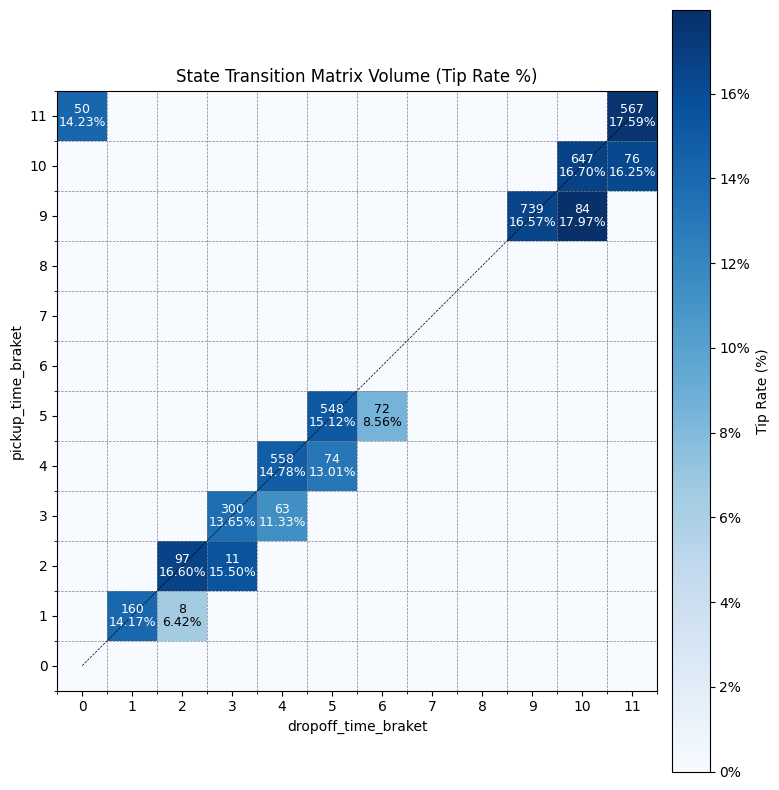

In [ ]:
plot_transition_matrix(
    transition_matrix_df=pdf.sort_index(ascending=False),
    color_transition_matrix_df=pdf_tip_pct.sort_index(ascending=False),
    title="State Transition Matrix Volume (Tip Rate %)",
    display_transition_rates=True,
    ax=None,
    figsize=(8, 8),
    fontsize=9,
    colorbar_label="Tip Rate (%)"
)
plt.tight_layout()